# Decision Trees

In [141]:
# Se importan las librerias a usar
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

## Sobre el conjunto de datos `drug200.csv`

El conjunto de datos contiene información sobre un grupo de pacientes, todos afectados por la misma enfermedad. Durante su tratamiento, cada paciente fue tratado con uno de los 5 medicamentos disponibles: Medicamento A, Medicamento B, Medicamento C, Medicamento X y Medicamento Y.

El objetivo es construir un modelo que determine qué medicamento podría ser adecuado para un paciente futuro con la misma enfermedad. Las características incluyen la edad, el sexo, la presión arterial y el colesterol de los pacientes, mientras que el objetivo es identificar el medicamento al que cada paciente respondió durante el tratamiento.[Dataset source](https://www.kaggle.com/datasets/prathamtripathi/drug-classification/data)

In [142]:
# Se importa el archivo
df = pd.read_csv('drug200.csv', delimiter=",")
# visualizamos el df
df.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,DrugY


EDA

In [143]:
# Verificamos el tipo de dato en las columnas
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          200 non-null    int64  
 1   Sex          200 non-null    object 
 2   BP           200 non-null    object 
 3   Cholesterol  200 non-null    object 
 4   Na_to_K      200 non-null    float64
 5   Drug         200 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 9.5+ KB


In [144]:
# Contamos los valores duplicados
df.duplicated().value_counts()

False    200
Name: count, dtype: int64

In [145]:
# Generamos estadísticas descriptivas para todas las columnas
df.describe(include='all')

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
count,200.000000,200,200,200,200.000000,200
unique,NaN,2,3,2,NaN,5
top,NaN,M,HIGH,HIGH,NaN,DrugY
freq,NaN,104,77,103,NaN,91
mean,44.315000,NaN,NaN,NaN,16.084485,NaN
std,16.544315,NaN,NaN,NaN,7.223956,NaN
min,15.000000,NaN,NaN,NaN,6.269000,NaN
25%,31.000000,NaN,NaN,NaN,10.445500,NaN
50%,45.000000,NaN,NaN,NaN,13.936500,NaN
75%,58.000000,NaN,NaN,NaN,19.380000,NaN


<Axes: xlabel='Age', ylabel='Count'>

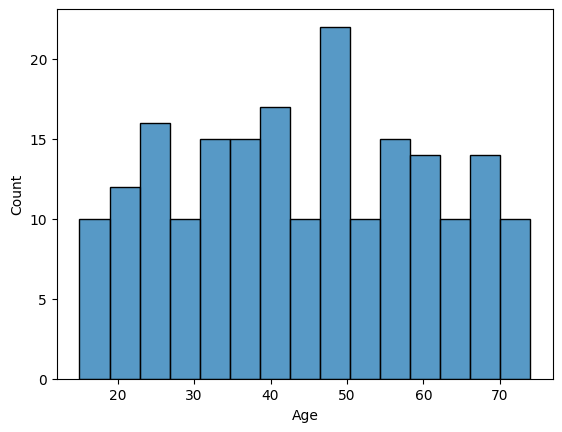

In [146]:
# Histograma Age
sns.histplot(df.Age, bins=15)


<Axes: xlabel='Sex', ylabel='count'>

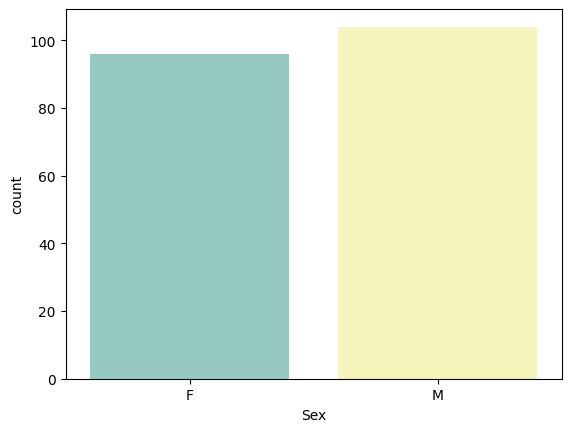

In [147]:
# Cantidad de personas por sexo
sns.countplot(x='Sex', data=df, hue='Sex', palette='Set3', legend=False)


Tenemos un conjunto de datos con 200 filas que incluye algunas variables categóricas. En el histograma, observamos que las edades de las personas van desde los 15 hasta los 74 años, con un pequeño pico entre los 45 y 50 años, donde se registra un total de 24 personas. Esto sugiere que, en promedio, contamos con personas de todas las edades de manera uniforme.

En cuanto a la distribución por sexo, podemos identificar que la mayoría son hombres, aunque la diferencia con respecto a las mujeres es mínima. Gracias a este análisis exploratorio de datos (EDA), podemos comprender mejor la composición de nuestro conjunto de datos.

## Preprocesamiento


In [148]:
# Seleccionamos nuestras variables predictoras
X = df[['Age',	'Sex',	'BP',	'Cholesterol',	'Na_to_K']]
# Obtener las columnas categóricas 
colum_categoricas = ['Sex', 'BP', 'Cholesterol']
# Crear un objeto OneHotEncoder
onehot_encoder = OneHotEncoder(categories='auto', sparse_output=False)
# Crear una transformación de columnas para aplicar el OneHotEncoder a las columnas categóricas
preproceso = ColumnTransformer(
    transformers=[('onehot', onehot_encoder, colum_categoricas)],
    remainder='passthrough')  # Las columnas no especificadas se mantienen sin cambios

# Aplicar la transformación a X
X = preproceso.fit_transform(X)

# Mostrar las primeras 5 filas de X_encoded
X[0:5]

array([[ 1.   ,  0.   ,  1.   ,  0.   ,  0.   ,  1.   ,  0.   , 23.   ,
        25.355],
       [ 0.   ,  1.   ,  0.   ,  1.   ,  0.   ,  1.   ,  0.   , 47.   ,
        13.093],
       [ 0.   ,  1.   ,  0.   ,  1.   ,  0.   ,  1.   ,  0.   , 47.   ,
        10.114],
       [ 1.   ,  0.   ,  0.   ,  0.   ,  1.   ,  1.   ,  0.   , 28.   ,
         7.798],
       [ 1.   ,  0.   ,  0.   ,  1.   ,  0.   ,  1.   ,  0.   , 61.   ,
        18.043]])

In [149]:
# Seleccionamos nuestra variable objetivo
y = df['Drug'].values
y[0:5]

array(['DrugY', 'drugC', 'drugC', 'drugX', 'DrugY'], dtype=object)

Aplicamos el preprocesamiento a nuestro modelo principalmente para convertir las variables categóricas en una forma numérica que pueda ser interpretada por el algoritmo de machine learning. Esto nos permite incluir toda la información relevante en el modelo sin perder la capacidad de análisis de las variables categóricas.

## Configurar el árbol de decisiones

In [150]:
# Se divide el dataset en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=3)
print('Train set', X_train.shape, y_train.shape)
print('Test set', X_test.shape, y_test.shape)

Train set (140, 9) (140,)
Test set (60, 9) (60,)


In [151]:
# Crear un clasificador de árbol de decisiones sin especificar hiperparámetros
tree = DecisionTreeClassifier()

# Entrenar el clasificador utilizando los datos de entrenamiento
tree.fit(X_train, y_train)

# Predecir las etiquetas de clase para los datos de prueba
y_pred = tree.predict(X_test)

# Evaluar el modelo calculando la precisión de las predicciones
print("Precisión del árbol de decisiones: ", metrics.accuracy_score(y_test, y_pred))


Precisión del árbol de decisiones:  0.9833333333333333


Una precisión del 98% en un modelo de árbol de decisiones generalmente se considera bastante buena. Indica que el modelo fue capaz de predecir correctamente la clase de la variable objetivo en el 98% de las muestras de prueba.

In [152]:
# Crear la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
# Calcular los valores
TP = conf_matrix[0][0]
FP = sum(conf_matrix[1:][0])
FN = sum(conf_matrix[0][1:])
TN = sum(sum(row) for i, row in enumerate(conf_matrix) if i > 0) - FP

# Mostrar los valores
print(f'Verdaderos Positivos (TP): {TP}')
print(f'Verdaderos Negativos (TN): {TN}')
print(f'Falsos Positivos (FP): {FP}')
print(f'Falsos Negativos (FN): {FN}')

Verdaderos Positivos (TP): 22
Verdaderos Negativos (TN): 31
Falsos Positivos (FP): 7
Falsos Negativos (FN): 0


El resultado de la matriz de confusión muestra que el modelo de clasificación  tiene un rendimiento bastante bueno en general, especialmente en términos de verdaderos positivos (TP) y verdaderos negativos (TN), que son altos.

## Optimización de Hiperparámetros con Grid Search

In [153]:
# Definir los parámetros que deseas probar
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Crear un objeto GridSearchCV
grid_search = GridSearchCV(estimator=DecisionTreeClassifier(), param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Realizar la búsqueda de cuadrícula en los datos de entrenamiento
grid_search.fit(X_train, y_train)

# Mostrar los mejores hiperparámetros encontrados
print("Mejores hiperparámetros encontrados:")
print(grid_search.best_params_)

# Obtener el mejor modelo entrenado
best_model = grid_search.best_estimator_

# Calcular la precisión en los datos de prueba
accuracy = best_model.score(X_test, y_test)
print(f"Precisión del mejor modelo en datos de prueba: {accuracy}")


Fitting 5 folds for each of 72 candidates, totalling 360 fits
Mejores hiperparámetros encontrados:
{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}
Precisión del mejor modelo en datos de prueba: 0.9833333333333333


En el proyecto, hamos utilizado GridSearchCV para encontrar los mejores hiperparámetros para un modelo de árbol de decisiones. Después de realizar la búsqueda en la cuadrícula, se ha encontrado que los mejores hiperparámetros son criterion='gini', max_depth=5, min_samples_leaf=1 y min_samples_split=2.

A pesar de que la precisión del mejor modelo en los datos de prueba sigue siendo la misma que antes de la búsqueda en la cuadrícula, es importante tener en cuenta que la búsqueda en la cuadrícula ha permitido encontrar una configuración óptima de hiperparámetros que puede mejorar el rendimiento del modelo en datos no vistos.